In [2]:
# Libraries used
using DataFrames;
using CSV;
using Plots;

In [3]:
support2 = CSV.read("support2.csv", DataFrame, delim = ',');
first(support2, 2)

Row,id,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
,Int64,Float64,Int64,String7,Int64,Int64,Int64,String31,String31,Int64,Int64?,String15?,Int64?,Float64?,Float64?,Float64?,Float64?,String15?,Float64?,Int64?,Float64?,Float64?,Int64,Int64,Int64,String15,Float64?,Float64?,String15?,Int64?,Float64?,Float64?,Float64?,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Float64?,Float64?,Float64?,Int64?,Int64?,String31?,Float64
1,1,62.85,0,male,0,5,2029,Lung Cancer,Cancer,0,11,$11-$25k,0,9715.0,missing,missing,7.0,other,33.8984,20,0.262939,0.0369949,1,0,0,metastatic,0.5,0.25,no dnr,5,97.0,6.0,69.0,22,36.0,388.0,1.7998,0.199982,1.19995,141,7.45996,missing,missing,missing,7,7,missing,7.0
2,2,60.339,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12,$11-$25k,44,34496.0,missing,missing,29.0,white,52.6953,74,0.000999928,0.0,3,0,0,no,0.0,0.0,missing,missing,43.0,17.0977,112.0,34,34.5938,98.0,missing,missing,5.5,132,7.25,missing,missing,missing,missing,1,<2 mo. follow-up,1.0


In [4]:
id_col = ["id"];
target_cols = ["death", "hospdead"];
ordinal_feats = ["id", "edu", "income", "sfdm2"];

categorical_feats = names(support2, Union{Missing, AbstractString});
numerical_feats = names(select(support2, Not(ordinal_feats)), Union{Missing, Number});

In [5]:
summary = describe(select(support2, Not(ordinal_feats)))
show(summary, allrows=true, allcols=true)

44×7 DataFrame
 Row │ variable  mean       min                median    max           nmissing  eltype                   
     │ Symbol    Union…     Any                Union…    Any           Int64     Type                     
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ age       62.6508    18.042             64.857    101.848              0  Float64
   2 │ death     0.681054   0                  1.0       1                    0  Int64
   3 │ sex                  female                       male                 0  String7
   4 │ hospdead  0.259198   0                  0.0       1                    0  Int64
   5 │ slos      17.863     3                  11.0      343                  0  Int64
   6 │ d.time    478.45     3                  233.0     2029                 0  Int64
   7 │ dzgroup              ARF/MOSF w/Sepsis            MOSF w/Malig         0  String31
   8 │ dzclass              ARF/MOSF            

# Single model training

In [32]:
include("fluxANNs.jl") # for ANN training with Flux
include("evaluation.jl") # for confusion matrix calculation and cross validation set partitioning
include("preprocessing.jl") # for normalization, one-hot encoding, holdout division

using ScikitLearn;
using PyCall;

@sk_import svm: SVC
@sk_import tree: DecisionTreeClassifier
# this gives me an error
# @sk_import neighbours: KNeighborsClassifier
# however this works for me
sklearn = pyimport("sklearn.neighbors")
KNeighborsClassifier = sklearn.KNeighborsClassifier

Random.seed!(10)


function fitScikitModel(modelType::Symbol, modelHyperparameters::Dict, 
                        (inputsTrain, targetsTrain)::Tuple{AbstractArray{<:Real,2}, AbstractArray{<:Any,1}})
    
    if modelType == :SVM
        model = SVC(kernel=modelHyperparameters["kernel"], 
                    degree=modelHyperparameters["degree"], 
                    gamma=modelHyperparameters["gamma"], 
                    C=modelHyperparameters["C"]);
    elseif modelType == :DTree
        model = DecisionTreeClassifier(max_depth=modelHyperparameters["maxDepth"], 
                                        random_state=1);
    elseif modelType == :KNN
        model = KNeighborsClassifier(modelHyperparameters["k"]);
    else
        println("Unknown model type ", modelType)
        return -1
    end;
    
    fit!(model, inputsTrain, targetsTrain);
    
    return model
end

function fitAndConfusion(modelType::Symbol, modelHyperparameters::Dict, 
                        (inputsTrain, targetsTrain)::Tuple{AbstractArray{<:Real,2}, AbstractArray{<:Any,1}},
                        (inputsVal, targetsVal)::Tuple{AbstractArray{<:Real,2}, AbstractArray{<:Any,1}},
                        (inputsTest, targetsTest)::Tuple{AbstractArray{<:Real,2}, AbstractArray{<:Any,1}},
                        classes::AbstractArray{<:Any,1})
    
    if modelType == :ANN
        
        targetsTrain = oneHotEncoding(targetsTrain, classes)
        targetsVal = oneHotEncoding(targetsVal, classes)
        targetsTest = oneHotEncoding(targetsTest, classes)
        
        (ann, _) = trainClassANN(modelHyperparameters["topology"], (inputsTrain, targetsTrain), 
                                (inputsVal, targetsVal), (inputsTest, targetsTest);
                                maxEpochs=modelHyperparameters["maxEpochs"], 
                                minLoss=modelHyperparameters["minLoss"],
                                learningRate=modelHyperparameters["learningRate"],
                                maxEpochsVal=modelHyperparameters["maxEpochsVal"]);
        
        outputsTest = ann(inputsTest')';
    else
        model = fitScikitModel(modelType, modelHyperparameters, (inputsTrain, targetsTrain)) 
        outputsTest = predict(model, inputsTest);
    end
    
    return confusionMatrix(outputsTest, targetsTest; weighted=true)
end

function modelCrossValidation(modelType::Symbol,
        modelHyperparameters::Dict,
        inputs::AbstractArray{<:Real,2},
        targets::AbstractArray{<:Any,1},
        crossValidationIndices::Array{Int64,1})
    classes = unique(targets)
    trainingDataset = (inputs, targets);
    repetitionsTraining = 1

    if modelType == :ANN
        # set to more than one because ANNs are non-deterministic
        repetitionsTraining = 10
    end;
    
    k = kFoldIndices[argmax(crossValidationIndices)]
    results = zeros(k, 2)
    
    for testGroup=1:k
        metrics = []
        
        # computing training, test
        indicesTraining = findall(!=(testGroup), kFoldIndices)
        indicesTest = findall(==(testGroup), kFoldIndices)

        trainingDataset = inputs[indicesTraining,:], targets[indicesTraining]
        testDataset = inputs[indicesTest,:], targets[indicesTest]

        # normalization and validation set computation if needed
        valRatio = if modelType != :ANN 0. else modelHyperparameters["validationRatio"] end
        trainingDataset, validationDataset, testDataset = prepareDataForFitting(trainingDataset, testDataset, valRatio)
        
        for _ = 1:repetitionsTraining
            (accur, _, _, _, _, _, fScore) = fitAndConfusion(modelType, modelHyperparameters, 
                                                    trainingDataset, validationDataset, testDataset, classes);
            push!(metrics, [accur, fScore])
        end;
        
        results[testGroup, :] = mean(metrics)
    end;
    
    return mean(results, dims=1), std(results, dims=1)
end

modelCrossValidation (generic function with 1 method)

In [33]:

# loading the dataset
df_clean = dropmissing(support2, numerical_feats)
inputs = Array(df_clean[!,numerical_feats]);
targets = convert(Array{Bool, 1}, Array(df_clean[!,:death]));

kFoldIndices = crossvalidation(targets, 5)

# definition of models to train
models = []

DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16)]

KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12)]

SVMparams = [Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "rbf", "degree" => 3, "gamma" => 30, "C" => 1), # higher gamma
            Dict("kernel" => "sigmoid", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 6, "gamma" => 2, "C" => 1)] # higher degree

ANNparams = [Dict("topology" => [3, 8], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [6, 16], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:KNN, KNNparams),(:DTree, DTreeParams),(:SVM, SVMparams),(:ANN, ANNparams)]

bestMetricYet = 0
bestModel = -1

for (modelType, paramList) in models
    cnt = 1
    println("Training ", modelType, " models:")
    for params in paramList
        (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, inputs, targets, kFoldIndices)
        println("Configuration ", cnt)
        println("Accuracy:", accur, ", stdDev:", stdAccur)
        println("F1-Score:", fScore, ", stdDev:", stdFScore)
        println()
        cnt += 1
        #println(modelType, (accur, fScore), (stdAccur, stdFScore))
        if accur * fScore > bestMetricYet
            bestMetricYet = accur * fScore
            bestModel = (modelType, params)
        end
    end
end

(modelType, params) = bestModel
println("Best model is ", modelType, " with hyperparameters:")
println(params)

Training KNN models:
Configuration 1

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7118c79a5760>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr


Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Configuration 2
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Configuration 3
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Training DTree models:
Configuration 1
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Configuration 2
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Configuration 3
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Training SVM models:
Configuration 1

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7118c79a7100>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr


Accuracy:0.9713131270727509, stdDev:0.013459668719403113
F1-Score:0.47699712407648687, stdDev:0.0460626973138567

Configuration 2
Accuracy:0.5371793795390623, stdDev:0.0028144901046004834
F1-Score:0.1497024372237078, stdDev:0.20498881171809477

Configuration 3
Accuracy:0.5371793795390623, stdDev:0.0028144901046004834
F1-Score:0.1497024372237078, stdDev:0.20498881171809477

Configuration 4
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Configuration 5
Accuracy:1.0, stdDev:0.0
F1-Score:0.4917404810881155, stdDev:0.040626710639260676

Training ANN models:
Configuration 1
Accuracy:0.9284766942333794, stdDev:0.07316905958645002
F1-Score:0.913663912303386, stdDev:0.12420155408512287

Configuration 2
Accuracy:0.9011382113821138, stdDev:0.14186519180134588
F1-Score:0.8177528089887641, stdDev:0.26648454623514045

Configuration 3
Accuracy:0.9976190476190476, stdDev:0.005323971374999579
F1-Score:0.997752808988764, stdDev:0.005024871859550101

Best model is ANN

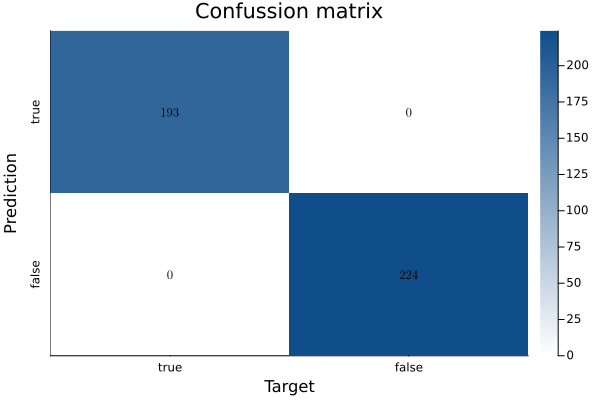

In [34]:
using Plots;
include("evaluation.jl") # for confusion matrix calculation and cross validation set partitioning

# train best model with all paterns and build confusion matrix with all patterns
train = (inputs, targets); test = train;

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(targets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

displayConfMat(confMat, classes)

# Ensemble training

In [35]:
@sk_import ensemble:StackingClassifier

function trainClassEnsemble(estimators::AbstractArray{Symbol,1},
        modelsHyperParameters:: AbstractArray{Dict, 1},
        trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}},
        kFoldIndices::     Array{Int64,1})
    (inputs, targets) = trainingDataset;
    classes = unique(targets)
    
    k = kFoldIndices[argmax(kFoldIndices)]
    results = zeros(k, 2)
    
    for testGroup=1:k
        # computing training and test sets
        indicesTraining = findall(!=(testGroup), kFoldIndices)
        indicesTest = findall(==(testGroup), kFoldIndices)
        trainingDataset = inputs[indicesTraining,:], targets[indicesTraining]
        testDataset = inputs[indicesTest,:], targets[indicesTest]
        trainInputs, trainTargets = trainingDataset
        testInputs, testTargets = testDataset

        # normalization is applied
        trainingDataset, _, testDataset = prepareDataForFitting(trainingDataset, testDataset)

        # each individual model is fitted
        modelsEnsemble = []
        for i = 1:length(estimators)
            modelType = estimators[i]
            modelHyperparameters = modelsHyperParameters[i]
            
            model = fitScikitModel(modelType, modelHyperparameters, trainingDataset);
            
            push!(modelsEnsemble, (string(modelType)*string(i), model))
        end;

        # the ensemble is built, trained and tested
        ensemble = StackingClassifier(estimators=[(name,model) for (name, model) in modelsEnsemble],
                    final_estimator = SVC(probability=true), n_jobs=-1)
        fit!(ensemble, trainInputs, trainTargets)
        outputsTest = predict(ensemble, testInputs);

        (accur, _, _, _, _, _, fScore) = confusionMatrix(outputsTest, testTargets; weighted=true)
        results[testGroup, :] = [accur, fScore]
    end;
    return mean(results, dims=1), std(results, dims=1)
end

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
modelsEnsemble = [:KNN, :DTree, :SVM]
params = []

DTreeParams = Dict("maxDepth" => 8)

KNNparams = Dict("k" => 6)

SVMparams = Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

trainClassEnsemble(modelsEnsemble, params, (inputs, reshape(targets, length(targets), 1)), crossvalidation(targets, 5))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7118c79865c0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

([1.0 0.49139204903236633], [0.0 0.0405361956572081])